c:\Users\Biswajit Palit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


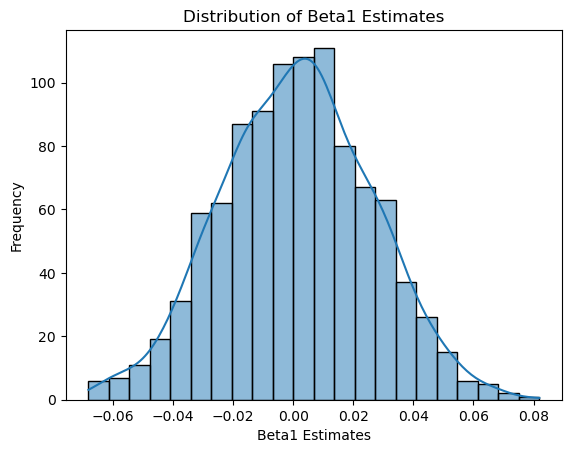

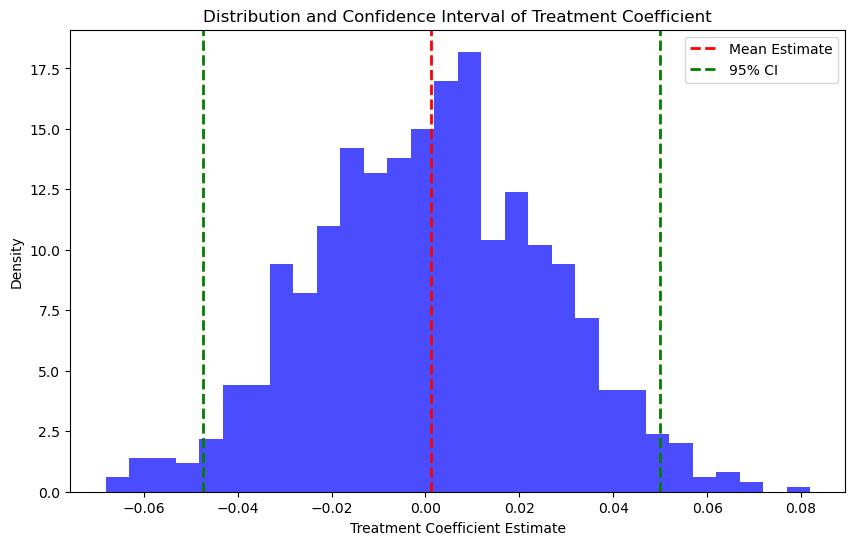

Number of times null hypothesis is rejected for 0.2: 44 out of 1000 simulations
Type 1 Error: 0.044
Bias for Coefficient of Treatment (True Value = 0): 0.0012498388680195233
Average MSE for Coefficient of Treatment (True Value = 0): 0.0006172715873694512
Average Standard Error for Coefficient of Treatment: 0.024919497850529708
Standard Error of the Distribution of Beta: 0.024813494114562722


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from monte_carlo_ar1 import (generate_staggered_law_ar1_data)

np.random.seed(42)

beta1_estimates = []
reject_count = 0  # Counter for the number of rejections
alpha = 0.05  # Significance level
num_simulations = 1000
num_individuals = 20
bias_values = []
squared_error_values = []
standard_error_values = []  # List to store standard errors
N = 50
T = 20
rho = 0.2
true_beta1_value = 0

for _ in range(num_simulations):
    data = generate_staggered_law_ar1_data(N, T, rho, num_individuals)
    states = data['state'].unique()

    treatment_states = np.random.choice(states, size=len(states), replace=False)

    # Assign treatment year to each treatment state, staggered between 1985 and 1995
    treatment_years = np.random.choice(range(5, 15), size=len(treatment_states)//2, replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Add a treatment column to the DataFrame
    data['TREATMENT'] = data.apply(lambda x: 1 if x['state'] in treatment_states and x['state'] in state_to_treatment_year and x['time'] >= state_to_treatment_year[x['state']] else 0, axis=1)

    a = state_to_treatment_year.keys()

    filtered_df = data[data['state'].isin(a)]

    # Separate pre-treatment and post-treatment data
    pre_treatment_df = filtered_df[filtered_df['TREATMENT'] == 0]
    post_treatment_df = filtered_df[filtered_df['TREATMENT'] == 1]

    # Calculate the average residuals for pre-treatment and post-treatment periods
    avg_residuals_pre_treatment = pre_treatment_df.groupby('state')['value'].mean().reset_index()
    avg_residuals_post_treatment = post_treatment_df.groupby('state')['value'].mean().reset_index()

    # Add a 'Treatment' column to indicate the treatment status for each period
    avg_residuals_pre_treatment['Treatment'] = 0
    avg_residuals_post_treatment['Treatment'] = 1

    # Combine the two DataFrames into a new DataFrame
    two_period_panel_df = pd.concat([avg_residuals_pre_treatment, avg_residuals_post_treatment], ignore_index=True)

    # Define the dependent and independent variables
    state_dummies = pd.get_dummies(two_period_panel_df['state'], prefix='state', drop_first=True)

    # Convert state dummy variables to int
    state_dummies = state_dummies.astype(int)
    two_period_panel_df = pd.concat([two_period_panel_df, state_dummies], axis=1)

    y = two_period_panel_df['value']
    X = two_period_panel_df.drop(columns=['value'])

    # Add a constant term (intercept) to the independent variables
    X = sm.add_constant(X)

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Extract the standard error of the 'Treatment' coefficient
    standard_error = model.bse['Treatment']
    standard_error_values.append(standard_error)

    bias = model.params['Treatment'] - true_beta1_value
    bias_values.append(bias)

    squared_error = (model.params['Treatment'] - true_beta1_value) ** 2
    squared_error_values.append(squared_error)

    # Check if null hypothesis for beta1 is rejected
    if model.pvalues['Treatment'] < alpha:
        reject_count += 1

    # Store the beta estimate
    beta1_estimates.append(model.params['Treatment'])

type1_error = reject_count / num_simulations
average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error_values)
average_standard_error = np.mean(standard_error_values)

# Calculate the standard error of the distribution of beta
std_error_beta_distribution = np.std(beta1_estimates)

sns.histplot(beta1_estimates, kde=True)
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.title('Distribution of Beta1 Estimates')
plt.show()

# Calculate the confidence interval
confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)

# Plot the confidence interval
plt.figure(figsize=(10, 6))
plt.hist(beta1_estimates, bins=30, density=True, color='blue', alpha=0.7)
plt.axvline(np.mean(beta1_estimates), color='red', linestyle='dashed', linewidth=2, label='Mean Estimate')
plt.axvline(confidence_interval[0], color='green', linestyle='dashed', linewidth=2, label='95% CI')
plt.axvline(confidence_interval[1], color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Treatment Coefficient Estimate')
plt.ylabel('Density')
plt.title('Distribution and Confidence Interval of Treatment Coefficient')
plt.legend()
plt.show()

# Print the results
print(f"Number of times null hypothesis is rejected for {rho}: {reject_count} out of {num_simulations} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment (True Value = {true_beta1_value}): {average_bias}")
print(f"Average MSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_mse}")
print(f"Average Standard Error for Coefficient of Treatment: {average_standard_error}")
print(f"Standard Error of the Distribution of Beta: {std_error_beta_distribution}")


In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from monte_carlo_ar1 import (generate_staggered_law_ar1_data)
import scipy.stats as stats

np.random.seed(42)

def beta_Ztest_twosided(alpha, std_err, mu_0, mu):
    # (1-alpha)-quantile of N(0,1):
    z_upper = stats.norm.ppf(1 - alpha)
    
    # location shift under H_1:
    location_shift = (mu - mu_0) / std_err
    
    # compute power
    power = 1 - stats.norm.cdf(z_upper - location_shift)
    
    return power

beta1_estimates = []
reject_count = 0  # Counter for the number of rejections
alpha = 0.05  # Significance level
num_simulations = 100
num_individuals = 500
bias_values = []
squared_error_values = []
standard_error_values = []  # List to store standard errors
N = 50
T = 20
rho = 0.8
true_beta1_value = 0
power_values = []
n = N * T * num_individuals
alternate_beta1_value = 0.02
reject_count_2 = 0

for _ in range(num_simulations):
    data = generate_staggered_law_ar1_data(N, T, rho, num_individuals)
    states = data['state'].unique()

    treatment_states = np.random.choice(states, size=len(states), replace=False)

    # Assign treatment year to each treatment state, staggered between 1985 and 1995
    treatment_years = np.random.choice(range(5, 15), size=len(treatment_states)//2, replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Add a treatment column to the DataFrame
    data['TREATMENT'] = data.apply(lambda x: 1 if x['state'] in treatment_states and x['state'] in state_to_treatment_year and x['time'] >= state_to_treatment_year[x['state']] else 0, axis=1)
    data['outcome'] = data.apply(lambda x: x['value']*(1.02) if x['TREATMENT'] == 1 else x['value'], axis=1)
    
    a = state_to_treatment_year.keys()

    filtered_df = data[data['state'].isin(a)]

    # Separate pre-treatment and post-treatment data
    pre_treatment_df = filtered_df[filtered_df['TREATMENT'] == 0]
    post_treatment_df = filtered_df[filtered_df['TREATMENT'] == 1]

    # Calculate the average residuals for pre-treatment and post-treatment periods
    avg_residuals_pre_treatment = pre_treatment_df.groupby('state')['outcome'].mean().reset_index()
    avg_residuals_post_treatment = post_treatment_df.groupby('state')['outcome'].mean().reset_index()

    # Add a 'Treatment' column to indicate the treatment status for each period
    avg_residuals_pre_treatment['Treatment'] = 0
    avg_residuals_post_treatment['Treatment'] = 1

    # Combine the two DataFrames into a new DataFrame
    two_period_panel_df = pd.concat([avg_residuals_pre_treatment, avg_residuals_post_treatment], ignore_index=True)

    # Define the dependent and independent variables
    state_dummies = pd.get_dummies(two_period_panel_df['state'], prefix='state', drop_first=True)

    # Convert state dummy variables to int
    state_dummies = state_dummies.astype(int)
    two_period_panel_df = pd.concat([two_period_panel_df, state_dummies], axis=1)

    y = two_period_panel_df['outcome']
    X = two_period_panel_df.drop(columns=['outcome'])

    # Add a constant term (intercept) to the independent variables
    X = sm.add_constant(X)

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Extract the standard error of the 'Treatment' coefficient
    standard_error = model.bse['Treatment']
    standard_error_values.append(standard_error)

    bias = model.params['Treatment'] - true_beta1_value
    bias_values.append(bias)

    squared_error = (model.params['Treatment'] - true_beta1_value) ** 2
    squared_error_values.append(squared_error)

    # Check if null hypothesis for beta1 is rejected
    if model.pvalues['Treatment'] < alpha:
        reject_count += 1

    if (model.params['Treatment'] - 0.02) / model.bse['Treatment'] > 1.64 :
        reject_count_2 += 1

    # Store the beta estimate
    beta1_estimates.append(model.params['Treatment'])
    
    power = beta_Ztest_twosided(alpha, standard_error, true_beta1_value, alternate_beta1_value)
    power_values.append(power)

average_power = np.mean(power_values)

print(f"Average Power: {average_power}")

reject_count_2




MemoryError: Unable to allocate 275. MiB for an array with shape (72, 500000) and data type float64